# Problem Statement

Given the recent impact of Covid-19, many people have decreased their visits to restaurants in order to comply with the social distancing orders from governments. As such, many people have turned to online food delivery services to satisfy their cravings and meals on a daily basis. However, many lesser known restaurants have suffered during this period due to the lack of customers and online orders especially if food delivery apps are consistently recommending other restaurants to their normal customers.

While many delivery apps recommend users restaurants based on their location proximity, what this Capstone Project aims to create is an **alternative food recommendation system** based on **user reviews and sentiment analysis.** As more and more people are starting to frequent restaurants again in Phase 2, this Capstone Project aims to help people become more aware of local Restaurants through this Recommendation System and help keep their businesses alive.

The Recommendation System Models will be built based on the **Yelp Reviews Dataset** on Kaggle, particularly focusing on Restaurant Reviews in the city of `Toronto`. With the models built out, this project can be applied to other cities as long as we can get similar datasets for such cities.

# Overview

This Capstone Project will apply **Natural Language Processing** on Yelp Restaurant Reviews in order to create new insights and features that can be used for the various Recommendation System Models.

Using **Sentiment Analysis** Packages like `Textblob` and `VADER`, we can analyze text reviews to derive further quantitative metrics on a user's overall sentiment and review of a restaurant visit. Combining sentiment scores with rating scores from reviews, we hope to build out a super score that better reflects a user's overall experience and feeling towards a restaurant. This super score will be used in our **Collaborative Filtering Recommendation System.**

Furthermore, this project will also incorporate **Topic Modelling (LDA)** to further classify text reviews based on several dominant topics. By identfying common key words in different dominant topics, we will use these key words in our **Content Based Recommendation System.**

Lastly, this project will use the longitude and latitude points of restaurants to build a **Location Based Recommendation System** and cluster restaurants together using the **K-Means Clustering Algorithm.**

# Explanatory Data Analysis

In [1]:
## Importing Basic Packages
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
pd.set_option('display.max_columns', 50)

# Import Plotly Packages
import plotly 
import plotly.offline as py
import plotly.graph_objs as go
import plotly_express as px
from plotly.offline import init_notebook_mode, plot, iplot


## sklearn Packages
import sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# Import NLP Packages
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import stylecloud

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

## Reading in CSV Files

In [2]:
# Reading in Restaurant Businesses Final CSV File

business_final = pd.read_csv("Data/Part_1/business_final.csv")
business_final.drop(['Unnamed: 0'], axis=1, inplace = True)
print(business_final.shape)
business_final.head(3)

(5471, 12)


business_id                      name     city state  stars  \
0  0QjROMVW9ACKjhSEfHqNCQ         Mi Mi Restaurant  Toronto    ON    4.0   
1  8k62wYhDVq1-652YbJi5eg              Tim Hortons  Toronto    ON    3.0   
2  PYLv9n0y8MimzTK2zCBoFw  GIG@bites Internet Cafe  Toronto    ON    3.0   

   review_count                                         categories   latitude  \
0           116                            Vietnamese, Restaurants  43.666376   
1             8  Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...  43.649859   
2             4  Home Services, Shopping, IT Services & Compute...  43.664707   

   longitude  is_open postal_code                     key  
0 -79.348773        1     M4M 1Y3  0QjROMVW9ACKjhSEfHqNCQ  
1 -79.382060        1     M5H 3V9  8k62wYhDVq1-652YbJi5eg  
2 -79.413939        1         M6G  PYLv9n0y8MimzTK2zCBoFw

There are a total of **5,471** Restaurant Businesses in the city of **Toronto** for our dataset.

In [3]:
# Reading in Reviews Final CSV File

reviews_final = pd.read_csv("Data/Part_1/reviews_final.csv")
reviews_final.drop(['Unnamed: 0'], axis=1, inplace = True)
#Drop key column as it contains the same values in the user_id column
reviews_final.drop(['key'], axis=1, inplace = True) 
print(reviews_final.shape)
reviews_final.head(3)

(253050, 11)


business_id                 user_id  stars  useful  funny  cool  \
0  qUWqjjjfpB2-4P3He5rsKw  TZQSUDDcA4ek5gBd6BzcjA    4.0       0      0     0   
1  9Eghhu_LzEJgDKNgisf3rg  iFEM16O5BeKvf_AHs6NzUQ    3.0       0      0     0   
2  jM6JjZXFAQQANwdlEwbH3g  IIE2OX5haarGNefY23R8BA    5.0       0      0     0   

                                                text                 date  \
0  In the heart of Chinatown, I discovered it enr...  2017-06-06 19:04:10   
1  Was super excited to bring my boyfriend to thi...  2016-08-25 16:25:12   
2  My absolutely favorite mushroom pizza in the c...  2016-04-23 03:32:19   

   year  month      time  
0  2017      6  19:04:10  
1  2016      8  16:25:12  
2  2016      4  03:32:19

In [4]:
# Reading in Users Final CSV File

users_final = pd.read_csv("Data/Part_1/users_final.csv")
users_final.drop(['Unnamed: 0'], axis=1, inplace = True)
print(users_final.shape)
users_final.head(3)

(44485, 10)


user_id   user_name  user_review_count      user_yelp_since  \
0  q-v8elVPvKz0KvK69QSj1Q  Lisa Marie                666  2009-05-19 01:42:25   
1  dIIKEfOgo0KqUfGQvGikPg        Gabi               2061  2007-08-10 19:01:51   
2  kxj7TPtJY2zbEjGV0PYfAA       Jenna               1399  2008-08-04 03:29:54   

                                             friends  useful_reviews  \
0  rt1KveqwFMnkN6dXKg5Qyg, NfnKx3z7zFottS3yHabw1g...            2993   
1  6Y-l3x4LpUNhTBVMTFmTmA, HYNhRw_-8g660mpnwY2VJA...           20024   
2  DecNq9BYtMwHhgdnPNGbVQ, rN36leHXl7n4LOJ_6Dh0zA...            7341   

   funny_reviews  cool_reviews  n_fans  average_stars  
0           1281          1832     197           3.37  
1           9684         16904     971           4.07  
2           4510          4912      89           3.82

## EDA on Toronto Restaurant Business Data

In [5]:
# Geographical Overview of Restaurants in Toronto City

px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
fig = px.scatter_mapbox(business_final, lat="latitude", lon="longitude", color="stars", size='review_count',
                   size_max=15, zoom=10, width=1000, height=800)
fig.update_layout(mapbox_style="dark")
fig.show()

Based on the plot, the area that has a high density of restaurants are located in the downtown city area of Toronto.

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

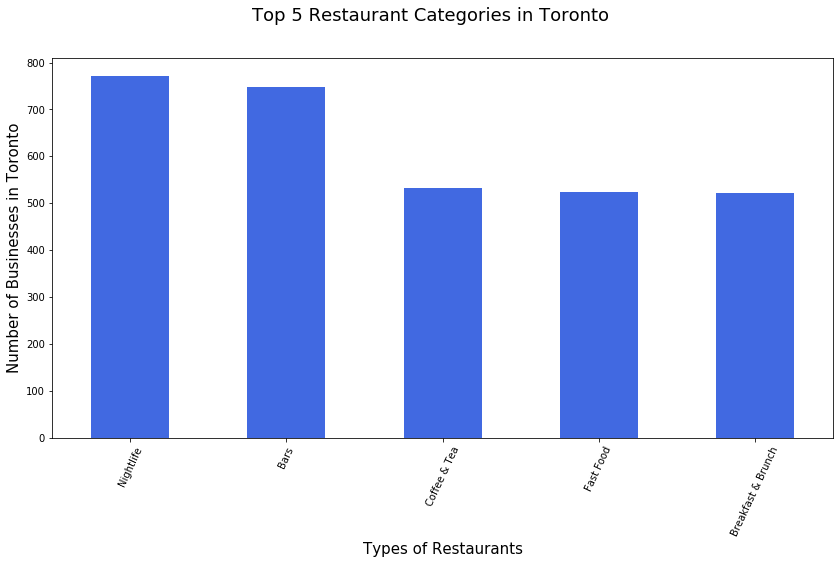

In [7]:
# Distribution of Types of Restaurant Categories 

restaurant_categories = business_final.assign(categories = business_final.categories.str.split(', ')).explode('categories')
top25_categories = restaurant_categories.categories.value_counts().head(7)

fig, ax = plt.subplots(figsize=(14, 7))
fig.suptitle('Top 5 Restaurant Categories in Toronto', fontsize=18)

# Excluding the top 2 most generic categories: Restaurants & Food

top25_categories[2:].plot(kind = 'bar', color = 'royalblue')

plt.ylabel('Number of Businesses in Toronto', fontsize=15)
plt.xlabel('Types of Restaurants', fontsize=15)
plt.xticks(rotation=65)

In [8]:
top25_categories

Restaurants           5461
Food                  1565
Nightlife              772
Bars                   748
Coffee & Tea           532
Fast Food              524
Breakfast & Brunch     522
Name: categories, dtype: int64

The most popular Restaurant Categories in Toronto are: `Nightlife`, `Bars`, `Coffee & Tea`, `Fast Food` & `Breakfast & Brunch`.

In [9]:
# Number of Unique Restaurant Categories

len(set(restaurant_categories['categories']))

353

There are a total of 353 unique Restaurant Categories.

In [10]:
# Overview of 'Nightlife' type of Restaurants in Toronto

toronto_nightlife = business_final[business_final['categories'].str.contains("Nightlife")]
print(toronto_nightlife.shape)
toronto_nightlife.head() # 772 Nightlife type of Restaurants

(772, 12)


business_id                       name     city state  stars  \
5   cicPsia8Wj-DNRkmLbD_xg  The Keg Steakhouse + Bar  Toronto    ON    3.5   
7   xVXyrTWbG8U3szze-aA7eg     St. Louis Bar & Grill  Toronto    ON    2.0   
24  tqumNKvNmeII_DRG6SdRuw     Best Bite Bar & Grill  Toronto    ON    4.5   
30  EwlA5wluJw5zzXxtA42brQ              Bar Centrale  Toronto    ON    4.0   
50  UPmrHkx4YmNo_QRniekP8g          The Rose & Crown  Toronto    ON    3.5   

    review_count                                         categories  \
5             91  Steakhouses, Restaurants, Nightlife, Seafood, ...   
7             34  Nightlife, Sports Bars, Bars, Restaurants, Ame...   
24            17  Pubs, American (Traditional), Turkish, Nightli...   
30             5   Restaurants, Bars, Wine Bars, Nightlife, Italian   
50            53  Sandwiches, Bars, Pubs, Music Venues, Restaura...   

     latitude  longitude  is_open postal_code                     key  
5   43.705842 -79.397841        1     M4S 2B2  cicPsia8Wj-DNRkmLbD_xg  
7   43.690144 -79.571658        1     M9W 1H7  xVXyrTWbG8U3szze-aA7eg  
24  43.653043 -79.600593        1     M9C 5K5  tqumNKvNmeII_DRG6SdRuw  
30  43.680037 -79.390519        1     M4W 2L8  EwlA5wluJw5zzXxtA42brQ  
50  43.708653 -79.398246        1     M4P 2C8  UPmrHkx4YmNo_QRniekP8g

In [11]:
toronto_nightlife.name.value_counts() #738 Unique Nightlife Restaurants

St. Louis Bar & Grill       8
Jack Astor's Bar & Grill    4
Loaded Pierogi              3
The Keg Steakhouse + Bar    3
Wild Wing                   3
                           ..
The Feathers Pub            1
Gallery Grill               1
Soco Kitchen and Bar        1
The Red Lantern             1
Jump Restaurant             1
Name: name, Length: 738, dtype: int64

Text(0, 0.5, 'Number of Restaurants')

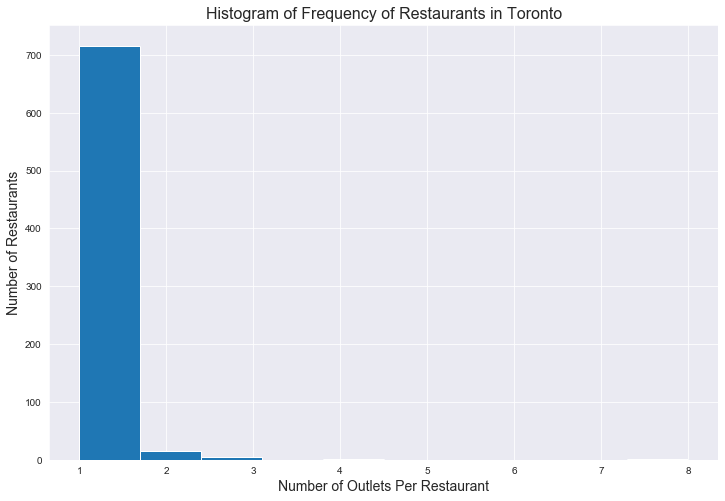

In [12]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,8))
plt.hist(toronto_nightlife.name.value_counts(), bins=10)
plt.title('Histogram of Frequency of Restaurants in Toronto', fontsize=16)
plt.xlabel('Number of Outlets Per Restaurant', fontsize=14)
plt.ylabel('Number of Restaurants', fontsize=14)

Based on the above value_count, we observe that there are multiple business entries for restaurants like `St. Louis Bar & Grill` and other restaurants as well, let's explore this further.

In [13]:
toronto_stlouis = toronto_nightlife[toronto_nightlife['name'].str.contains("St. Louis Bar & Grill")]
toronto_stlouis

business_id                    name     city state  stars  \
7     xVXyrTWbG8U3szze-aA7eg  St. Louis Bar & Grill  Toronto    ON    2.0   
695   dryad6tDgaGc-WsUUgPbfw  St. Louis Bar & Grill  Toronto    ON    3.0   
931   _ESIk0hZa3MdyxEsOlKv5Q  St. Louis Bar & Grill  Toronto    ON    2.5   
1289  hBqp4v9iKsM-6i56v0MBuQ  St. Louis Bar & Grill  Toronto    ON    2.5   
4160  2vBo1wWJckBnGOHhxt9ecg  St. Louis Bar & Grill  Toronto    ON    2.5   
4614  Pube7dRYQoptIn0OA0GpdQ  St. Louis Bar & Grill  Toronto    ON    3.5   
4790  INJ-1LC57mpAsNspyb3CfA  St. Louis Bar & Grill  Toronto    ON    3.0   
4804  mrwpkN8k5Q-X7J5mGQ0NtQ  St. Louis Bar & Grill  Toronto    ON    3.0   

      review_count                                         categories  \
7               34  Nightlife, Sports Bars, Bars, Restaurants, Ame...   
695             59  Bars, Sports Bars, Nightlife, Chicken Wings, A...   
931             56  Sports Bars, Bars, Argentine, Nightlife, Itali...   
1289            60  Sports Bars, Bars, Barbeque, Nightlife, Americ...   
4160            81  Sports Bars, Nightlife, Fast Food, Bars, Ameri...   
4614            49  Bars, Food, Sports Bars, Nightlife, Barbeque, ...   
4790            62  Nightlife, Sports Bars, Bars, Restaurants, Chi...   
4804            45  Pubs, Nightlife, Sports Bars, Bars, Restaurant...   

       latitude  longitude  is_open postal_code                     key  
7     43.690144 -79.571658        1     M9W 1H7  xVXyrTWbG8U3szze-aA7eg  
695   43.656584 -79.382704        1     M5G 2C2  dryad6tDgaGc-WsUUgPbfw  
931   43.663800 -79.384269        1     M4Y 1X9  _ESIk0hZa3MdyxEsOlKv5Q  
1289  43.777990 -79.344091        1     M2J 5A7  hBqp4v9iKsM-6i56v0MBuQ  
4160  43.640410 -79.390579        1     M5V 3V3  2vBo1wWJckBnGOHhxt9ecg  
4614  43.650073 -79.374891        1     M5C 2B8  Pube7dRYQoptIn0OA0GpdQ  
4790  43.701559 -79.397630        1     M4S 1Z9  INJ-1LC57mpAsNspyb3CfA  
4804  43.666300 -79.406203        1     M5S 1X2  mrwpkN8k5Q-X7J5mGQ0NtQ

In [14]:
# Geographical Overview of St Louis Bar & Grill Outlets in Toronto

px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
fig = px.scatter_mapbox(toronto_stlouis, lat="latitude", lon="longitude", color="stars", size='review_count',
                   size_max=15, zoom=10, width=1000, height=600)
fig.show()

There are 8 branches of the `St. Louis Bar & Grill` Restaurant in Toronto, all across different locations, each having a different business ID key.

In [16]:
# Sorting Toronto Restaurant Businesses based on the number of reviews per business

toronto_review_count = business_final.sort_values(by = 'review_count', ascending = False)
toronto_review_count

business_id                           name     city state  \
1699  r_BrIgzYcwo1NAuG9dLbpg     Pai Northern Thai Kitchen  Toronto    ON   
4822  RtUvSWO_UZ8V3Wpj0n077w        KINKA IZAKAYA ORIGINAL  Toronto    ON   
3742  aLcFhMe6DDJ430zelCpd2A                 Khao San Road  Toronto    ON   
3494  iGEvDk6hsizigmXhDKs2Vg  Seven Lives Tacos Y Mariscos  Toronto    ON   
4502  N93EYZy9R0sdlEvubu94ig                  Banh Mi Boys  Toronto    ON   
...                      ...                           ...      ...   ...   
2172  NzMcsVtG1sSQHFXFwcgRFg                  Lucky Dragon  Toronto    ON   
4486  lhERIwIdVIE-yB_1P7utVg                    Food Monks  Toronto    ON   
1078  0dyd0nX-42VW1QQEoJq1TQ        Nossa Casa Sports Cafe  Toronto    ON   
4494  fXYI--HjP8hCfwKfLZfTtg                     Starbucks  Toronto    ON   
3731  hhZmClwVLDPrbhmg3o2Srw            Sabor Del Pacifico  Toronto    ON   

      stars  review_count                                         categories  \
1699    4.5          2758  Restaurants, Thai, Specialty Food, Food, Ethni...   
4822    4.0          1592  Restaurants, Tapas/Small Plates, Japanese, Bar...   
3742    4.0          1542                                  Thai, Restaurants   
3494    4.5          1285                      Restaurants, Seafood, Mexican   
4502    4.5          1097  Sandwiches, Restaurants, Food, Vietnamese, Asi...   
...     ...           ...                                                ...   
2172    2.0             3                               Restaurants, Chinese   
4486    1.0             3  Home Services, Electricians, Plumbing, Food De...   
1078    4.5             3  Sports Bars, Nightlife, Sandwiches, Bars, Rest...   
4494    2.0             3   Cafes, Desserts, Coffee & Tea, Food, Restaurants   
3731    3.0             3             Colombian, Restaurants, Latin American   

       latitude  longitude  is_open postal_code                     key  
1699  43.647866 -79.388685        1     M5H 3G8  r_BrIgzYcwo1NAuG9dLbpg  
4822  43.660430 -79.378927        1     M5B 2A2  RtUvSWO_UZ8V3Wpj0n077w  
3742  43.646411 -79.393480        1     M5V 2H5  aLcFhMe6DDJ430zelCpd2A  
3494  43.654341 -79.400480        1     M5T 2K2  iGEvDk6hsizigmXhDKs2Vg  
4502  43.648827 -79.396970        1     M5V 2A9  N93EYZy9R0sdlEvubu94ig  
...         ...        ...      ...         ...                     ...  
2172  43.718603 -79.455399        1     M6A 2T2  NzMcsVtG1sSQHFXFwcgRFg  
4486  43.829632 -79.254021        1     M1V 5G4  lhERIwIdVIE-yB_1P7utVg  
1078  43.649342 -79.426482        1     M6J 1X8  0dyd0nX-42VW1QQEoJq1TQ  
4494  43.649616 -79.385447        1     M5H 2L2  fXYI--HjP8hCfwKfLZfTtg  
3731  43.719067 -79.507405        1     M3M 1A2  hhZmClwVLDPrbhmg3o2Srw  

[5471 rows x 12 columns]

In Toronto, the Restaurant that has the **highest reviews** has a total of **2,758 reviews** while the Restaurants with the **lowest reviews** has a total of **3 reviews.**

In [17]:
toronto_review_count.review_count.value_counts()

3      376
4      258
5      223
6      198
7      168
      ... 
573      1
561      1
537      1
529      1
899      1
Name: review_count, Length: 412, dtype: int64

Text(0, 0.5, 'Number of Restaurants')

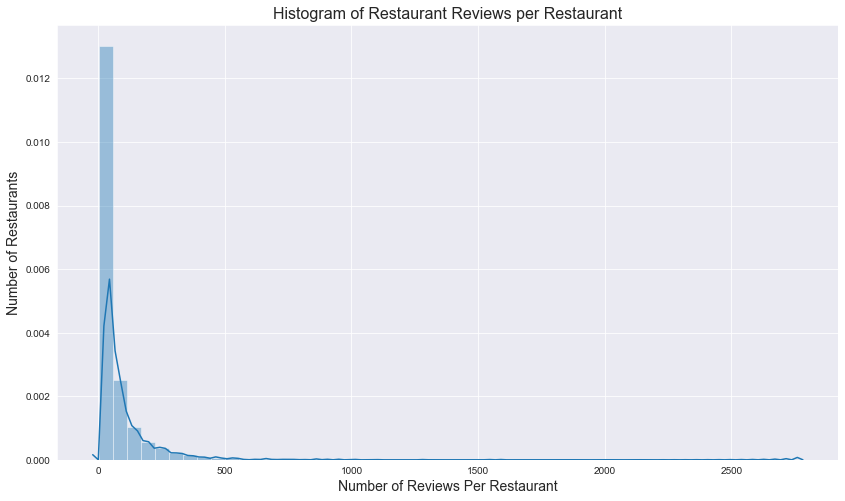

In [18]:
sns.set_style("darkgrid")
plt.figure(figsize=(14,8))
sns.distplot(toronto_review_count['review_count'])
plt.title('Histogram of Restaurant Reviews per Restaurant', fontsize = 16)
plt.xlabel('Number of Reviews Per Restaurant', fontsize=14)
plt.ylabel('Number of Restaurants', fontsize=14)

The distribution is skewed to the right, implying that most restaurants on average have a low number of reviews while fewer restaurants have a higher number of reviews.

## EDA on Reviews Data

In [19]:
# Overview of Reviews Data

print(reviews_final.shape)
reviews_final.head(3)

(253050, 11)


business_id                 user_id  stars  useful  funny  cool  \
0  qUWqjjjfpB2-4P3He5rsKw  TZQSUDDcA4ek5gBd6BzcjA    4.0       0      0     0   
1  9Eghhu_LzEJgDKNgisf3rg  iFEM16O5BeKvf_AHs6NzUQ    3.0       0      0     0   
2  jM6JjZXFAQQANwdlEwbH3g  IIE2OX5haarGNefY23R8BA    5.0       0      0     0   

                                                text                 date  \
0  In the heart of Chinatown, I discovered it enr...  2017-06-06 19:04:10   
1  Was super excited to bring my boyfriend to thi...  2016-08-25 16:25:12   
2  My absolutely favorite mushroom pizza in the c...  2016-04-23 03:32:19   

   year  month      time  
0  2017      6  19:04:10  
1  2016      8  16:25:12  
2  2016      4  03:32:19

In [20]:
# Overall Distribution of Restaurant Ratings from Yelp Users

data = reviews_final['stars'].value_counts().sort_index(ascending=False)

trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / reviews_final.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values
               )

# Create layout

layout = dict(title = 'Distribution Of {} Restaurant Ratings from Yelp Users'.format(reviews_final.shape[0]),
              xaxis = dict(title = 'Count'),
              yaxis = dict(title = 'Rating / Stars'))

# Create distribution plot

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

As seen from the above distribution plot, rating Scores are **skewed to the left** as most of the Ratings/Stars are 4 and 5 Scores.

# Sentiment Analysis

In [21]:
reviews_final['text'].head()

0    In the heart of Chinatown, I discovered it enr...
1    Was super excited to bring my boyfriend to thi...
2    My absolutely favorite mushroom pizza in the c...
3    Been to this a couple of times. Excellent food...
4    The pizza is very, very good! We arrived 15 mi...
Name: text, dtype: object

To further make sense of the data in our reviews dataset, we will be performing sentiment analysis on the text content of the reviews to understand user sentiment on their overall emotional experience dining at different restaurants.

Based on the overal reviews distribution plot in the previous section, we will be classifying negative reviews as those whose Star/Rating was `1` or `2` while classifying positive reviews as those whose Star/Rating was `5`. The remainder of the reviews whose Star/Rating was `3` or `4` will be classified as neutral reviews.

## Negative Reviews

In [22]:
# Filtering for negative reviews (one and two star)

one_star_reviews = reviews_final[reviews_final['stars'] == 1.0]
two_star_reviews = reviews_final[reviews_final['stars'] == 2.0]
negative_reviews = [one_star_reviews, two_star_reviews]
negative_reviews = pd.concat(negative_reviews)
print(negative_reviews.shape)
negative_reviews.sample(5)

(48496, 11)


business_id                 user_id  stars  useful  funny  \
65053   toYzcHwL9ueu1cPfjnAL9A  H4P3urFluCvsf4F1dqXe2Q    1.0       2      2   
104609  _eJ2ETotJBzZBQS15fD-8A  FoJkBMcjeIOye9mKQNfxsg    2.0       1      0   
239522  A7IQT6RYVSWkvEAbiLCdtQ  OSsaZToq22pl0YdcsDQuFQ    1.0       0      0   
160622  TAAlaXAk9sWOUXZW1-wfYQ  veqfgg2AkKs_L70fx1Quag    2.0       0      0   
102335  uChTCA6MsLAciDRklpO-Fw  5El0VTbAb-s0PgIcVbS6Kg    2.0       4      0   

        cool                                               text  \
65053      0  Very rude manager. Was rude and Kept on sluffi...   
104609     0  The service here was good but the restaurant w...   
239522     0  This place was utterly disgusting, the food wa...   
160622     0  We were there for Groupon. The service was ver...   
102335     0  I've been wanting to try this place for the lo...   

                       date  year  month      time  
65053   2018-09-29 06:12:04  2018      9  06:12:04  
104609  2016-02-01 00:29:28  2016      2  00:29:28  
239522  2017-06-03 01:30:48  2017      6  01:30:48  
160622  2017-07-14 01:53:19  2017      7  01:53:19  
102335  2017-08-29 20:05:28  2017      8  20:05:28

We have `48,496` rows of reviews data classified as **Negative Reviews.**

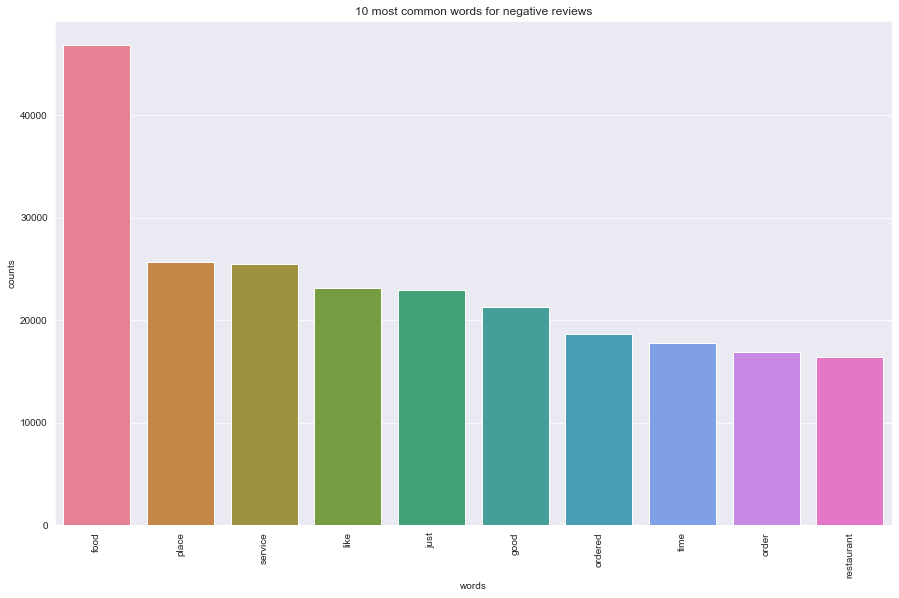

In [23]:
## Sentiment Analysis for Negative Reviews

def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words for negative reviews')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(negative_reviews['text'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

Words like `food`, `like`, `good`, `restaurant`, `place` are freqeuent words in negative reviews but on their own they are not very informative about the sentiment of negative reviews. Hence, we will look to remove these words before plotting our word cloud.

In [24]:
# Let's use the stop_words argument to remove words like "and, the, a"

stopwords = set(stopwords.words('english'))
cvec = CountVectorizer(min_df = 2, stop_words= stopwords, max_features = 1000)
cvec.fit(negative_reviews['text'])

# Transforming using our fitted cvec and converting the result to a DataFrame

negative_words = pd.DataFrame(cvec.transform(negative_reviews['text']).todense(),
                       columns=cvec.get_feature_names())

negative_top = negative_words.sum(axis = 0).sort_values(ascending = False).head(150)
negative_pd = pd.DataFrame(data=negative_top)
negative_top = negative_words[negative_pd.index]
negative_top.drop(columns=['food','like', 'restaurant', 'place', 'good'], inplace = True)
negative_top.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



service  us  one  would  ordered  time  order  back  get  came  even  go  \
0        0   0    0      1        1     2      1     0    4     1     0   1   
1        0   0    1      0        1     0      0     0    0     0     1   0   
2        0   3    1      0        0     0      0     1    0     1     0   0   
3        1   1    1      2        1     0      0     1    1     1     0   0   
4        0   0    0      0        0     0      0     0    1     0     0   0   

   really  chicken  got  table  asked  also  never  said  better  minutes  \
0       0        0    1      2      0     0      2     1       0        5   
1       1        0    0      0      0     0      0     0       0        0   
2       0        0    0      0      3     0      0     0       0        0   
3       0        0    0      0      0     0      0     0       0        0   
4       0        0    1      0      0     0      1     0       0        0   

   come  server  bad  ...  sushi  best  day  hour  busy  burger  waited  \
0     1       2    1  ...      0     0    0     1     0       0       0   
1     0       0    0  ...      0     0    0     0     1       0       0   
2     2       0    2  ...      0     0    0     0     0       0       0   
3     2       0    0  ...      0     0    1     0     0       2       0   
4     0       0    0  ...      0     0    0     0     0       0       0   

   served  side  dry  money  maybe  tables  waiter  pay  20  fresh  friends  \
0       0     0    0      0      0       0       0    0   2      0        0   
1       0     0    0      0      0       0       0    0   0      0        0   
2       0     0    0      0      0       0       3    0   0      0        0   
3       0     0    0      0      0       0       1    2   0      0        0   
4       0     0    0      0      0       0       0    0   0      0        0   

   recommend  bland  fried  hot  coming  overall  fish  
0          0      0      0    1       0        0     0  
1          0      0      0    0       0        0     0  
2          0      0      0    0       0        0     0  
3          0      0      0    0       0        0     0  
4          0      0      0    0       0        0     0  

[5 rows x 145 columns]

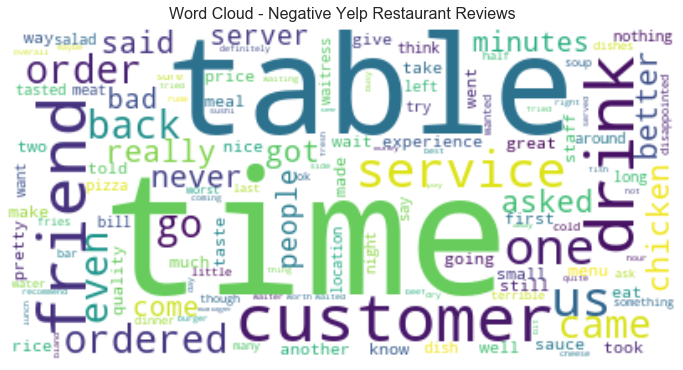

In [25]:
# Generate Word Cloud

wordcloud_low = WordCloud(background_color="white").generate(' '.join(negative_top))
plt.figure(figsize = (12,10))
plt.imshow(wordcloud_low, interpolation='bilinear')
plt.title('Word Cloud - Negative Yelp Restaurant Reviews', fontsize=16, y=1.01)
plt.axis("off");

In [26]:
negative_reviews['counter'] = 1
negative_reviews.head()

business_id                 user_id  stars  useful  funny  \
5   tJcpzXzykNSLuzWwa1JQUw  6WmMHMBM4FLGyK98-reecA    1.0       1      1   
16  L0T0tx47qXd15FOrLoKUng  w0G2GjGZrrzSwOr__j4B4w    1.0       2      0   
25  E-wETrdq1uImd6lX6x8Qxw  ymaFC3h-gqHwtzVznQw5JQ    1.0       2      0   
57  qcqDjeirxvdgW5kQVkEwSA  jsPWBtGTB0_jm-IW0y1KWw    1.0       1      1   
58  8QwAWJJ1FtICnE266xISMQ  gLsv77ETHn04kiFZwQIOJw    1.0       0      2   

    cool                                               text  \
5      1  With many eateries to chose from on queen stre...   
16     0  Ordered on Ritual but was not rdy when i went ...   
25     0  If there is negative rating, I will choose for...   
57     0  I didn't HATE the place! Hate is a strong word...   
58     0  I have never written a yelp review. Ever. This...   

                   date  year  month      time  counter  
5   2016-05-31 01:21:11  2016      5  01:21:11        1  
16  2018-02-23 22:35:50  2018      2  22:35:50        1  
25  2016-07-25 07:27:02  2016      7  07:27:02        1  
57  2016-02-23 20:36:11  2016      2  20:36:11        1  
58  2017-01-02 06:51:30  2017      1  06:51:30        1

In [27]:
# Sorting Restaurants based on number of reviews

negative_reviews.groupby('business_id')['counter'].sum().sort_values(ascending = False)

business_id
zgQHtqX0gqMw1nlBZl2VnQ    189
a8pmtlVKf7NiSLI-4KejIw    186
L3R7y3_tUKQlM9kor4-Ccw    177
RwRNR4z3kY-4OsFqigY5sw    175
O1TvPrgkK2bUo5O5aSZ7lw    142
                         ... 
d_BYcwM3_TDqYOoxFBNYXg      1
rZY8wtc4EyC_8o1mI2-_1A      1
dZxvdUmMp81stCt1SwKRiw      1
7mIBNG1OnTdDXg1ojrJvnw      1
V60xPUhZ88IJYnR4mJE92w      1
Name: counter, Length: 4755, dtype: int64

In [28]:
# Restaurant with most negative reviews

worst_restaurant = business_final[business_final['business_id '] == 'zgQHtqX0gqMw1nlBZl2VnQ']
worst_restaurant

business_id                  name     city state  stars  \
4137  zgQHtqX0gqMw1nlBZl2VnQ  Momofuku Noodle Bar  Toronto    ON    3.0   

      review_count                                         categories  \
4137          1010  Chinese, Soup, Ramen, Japanese, American (New)...   

       latitude  longitude  is_open postal_code                     key  
4137  43.649678 -79.386275        1     M5H 0A3  zgQHtqX0gqMw1nlBZl2VnQ

In [29]:
# Filtering Reviews from the Worst Restaurant

worst_restaurant_reviews = negative_reviews[negative_reviews['business_id'] == 'zgQHtqX0gqMw1nlBZl2VnQ']
worst_restaurant_reviews

business_id                 user_id  stars  useful  funny  \
175238  zgQHtqX0gqMw1nlBZl2VnQ  zmHpLrDO7pgOQ6_cnea_Qw    1.0       0      0   
175408  zgQHtqX0gqMw1nlBZl2VnQ  -Bflypa8Ds0h4nR7Qgea9Q    1.0       1      0   
176188  zgQHtqX0gqMw1nlBZl2VnQ  yEP9vNFq3edLldNzhm6hgQ    1.0       0      0   
176258  zgQHtqX0gqMw1nlBZl2VnQ  kJN998lZUKPbzYX3qSLc5Q    1.0       0      0   
176382  zgQHtqX0gqMw1nlBZl2VnQ  fM6SUpG8c5THjmf7_DblZg    1.0       0      0   
...                        ...                     ...    ...     ...    ...   
196322  zgQHtqX0gqMw1nlBZl2VnQ  6UV-2-QMTZnm_myN4Bxvxw    2.0       0      0   
196379  zgQHtqX0gqMw1nlBZl2VnQ  9FAGUsVR7kgPO9XYNwiFKA    2.0       3      3   
197056  zgQHtqX0gqMw1nlBZl2VnQ  qyZTCjP6c7CV-mEVpLGotQ    2.0       0      0   
197271  zgQHtqX0gqMw1nlBZl2VnQ  VwlyMlqexrfb3tnut812XQ    2.0       0      0   
197710  zgQHtqX0gqMw1nlBZl2VnQ  0kr1J81xoAft9gLdegkfmA    2.0       0      0   

        cool                                               text  \
175238     0  David Chang, seriously wth is wrong with you. ...   
175408     1  I visited Momofuku Noodle Bar when it first op...   
176188     0  I've heard so many things before I went there ...   
176258     0  This was very disappointing given this is the ...   
176382     0  Ramen is lacking flavourful broth, and does no...   
...      ...                                                ...   
196322     0  Sat at the upstairs bar. The bartender made me...   
196379     1  Momofuku, I disliked you, then I loved you, an...   
197056     0  Not my favorite ramen place and even the winte...   
197271     0  Their ramen is just 'okay'. Nothing special. D...   
197710     0  Review of Momofuku, Toronto\nFried Chicken Lar...   

                       date  year  month      time  counter  
175238  2018-06-08 23:39:04  2018      6  23:39:04        1  
175408  2018-07-26 15:01:50  2018      7  15:01:50        1  
176188  2018-07-08 21:14:44  2018      7  21:14:44        1  
176258  2017-04-20 02:30:09  2017      4  02:30:09        1  
176382  2016-04-12 16:01:08  2016      4  16:01:08        1  
...                     ...   ...    ...       ...      ...  
196322  2019-02-20 21:44:46  2019      2  21:44:46        1  
196379  2019-07-06 22:32:12  2019      7  22:32:12        1  
197056  2019-04-21 19:33:55  2019      4  19:33:55        1  
197271  2019-04-30 03:48:19  2019      4  03:48:19        1  
197710  2019-02-18 13:32:57  2019      2  13:32:57        1  

[189 rows x 12 columns]

In [30]:
# Let's use the stop_words argument to remove words like "and, the, a"

cvec = CountVectorizer(min_df = 2, stop_words= stopwords, max_features = 1000)
cvec.fit(worst_restaurant_reviews['text'])

# Transforming using our fitted cvec and converting the result to a DataFrame

negative_words = pd.DataFrame(cvec.transform(worst_restaurant_reviews['text']).todense(),
                       columns=cvec.get_feature_names())

negative_top = negative_words.sum(axis = 0).sort_values(ascending = False).head(300)
negative_pd = pd.DataFrame(data=negative_top)
negative_top = negative_words[negative_pd.index]
negative_top.drop(columns=['food','like', 'restaurant', 'place', 'good', 'better', 'great','noodles', 'ramen', 'pork', 'chicken', 'noodle', 'momofuku','nice','bar', 'broth', 'really', 'much','one','belly','bun', 'buns','even', 'us', 'got', 'go', 'came','milk'], inplace = True)
negative_top.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



would  service  get  ordered  back  time  also  come  experience  table  \
0      0        0    0        0     0     0     0     0           0      0   
1      2        1    0        0     0     0     0     0           0      0   
2      0        1    0        0     0     0     0     0           0      0   
3      2        0    1        0     0     0     0     0           0      0   
4      0        0    3        0     0     1     0     1           0      0   

   taste  bad  way  try  toronto  price  spicy  well  fried  ice  \
0      0    0    1    0        1      0      0     1      0    0   
1      0    0    0    1        2      0      2     0      0    0   
2      1    1    0    0        0      2      0     0      0    0   
3      0    0    0    0        1      1      0     0      0    0   
4      0    0    0    0        0      0      0     2      0    0   

   disappointed  tasted  nothing  people  order  ...  ask  compared  waiting  \
0             0       0        0       0      0  ...    0         0        0   
1             0       1        0       0      0  ...    0         0        0   
2             0       0        2       0      0  ...    0         0        0   
3             0       0        0       0      0  ...    0         0        0   
4             0       0        0       1      0  ...    0         0        0   

   leave  baos  hard  gave  tastes  hand  guess  everyone  heard  three  \
0      0     0     0     0       0     0      0         0      0      0   
1      0     0     0     0       0     0      0         0      0      0   
2      0     0     0     0       0     0      0         0      1      0   
3      0     0     0     0       0     0      0         0      0      0   
4      0     0     0     1       0     1      0         0      0      0   

   paying  hostess  hotel  truffle  lacked  walk  literally  whole  mind  12  \
0       0        0      0        0       0     0          0      0     0   0   
1       0        0      0        0       0     0          0      0     0   0   
2       0        0      3        0       0     0          0      0     0   0   
3       0        0      0        0       0     0          0      0     0   0   
4       0        0      0        0       0     0          0      0     0   0   

   huge  low  
0     0    0  
1     0    0  
2     0    0  
3     0    0  
4     0    0  

[5 rows x 272 columns]

In [31]:
column_list = list(negative_top)
negative_words = negative_top[column_list].sum(axis=0)
negative_words = negative_words.to_frame(name = 'sum').reset_index()
negative_words.set_index('index',inplace = True)
negative_words.to_csv("Data/Part_2/negative_words.csv")

In [32]:
negative_words.shape

(272, 1)

In [41]:
thumbs_down = stylecloud.gen_stylecloud(file_path="Data/Part_2/negative_words.csv", 
                                        icon_name = "fas fa-thumbs-down",
                                        size = 550,
                                        palette="colorbrewer.sequential.RdPu_3", 
                                        background_color="white",
                                        output_name = 'Data/Part_2/Negative_Reviews.png')

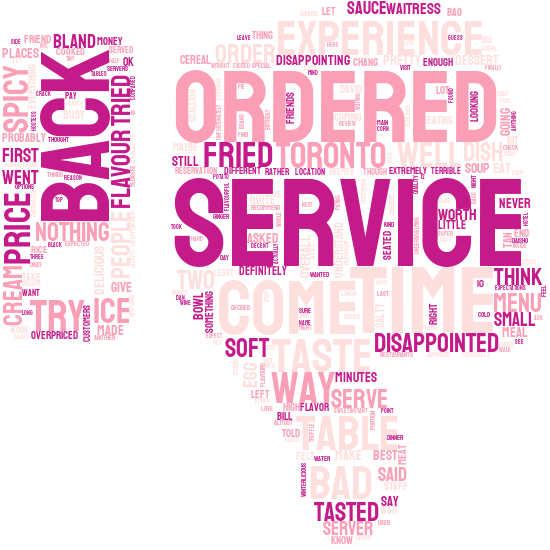

In [42]:
from IPython.display import Image
Image(filename='Data/Part_2/Negative_Reviews.png')

## Positive Reviews

In [43]:
# Filtering for positive reviews (five star)

positive_reviews = reviews_final[reviews_final['stars'] == 5.0]
print(positive_reviews.shape)
positive_reviews.sample(5)

(86573, 11)


business_id                 user_id  stars  useful  funny  \
143077  75gAUZTD5RoOLvRb5axJSw  USuSxqnlSOIsFXn-AVLTSw    5.0       0      0   
81197   r_BrIgzYcwo1NAuG9dLbpg  xWGBeeHgTFeXFGFNsnMg1g    5.0       0      0   
44205   WbS58nfQQZaxWk1BUPBuJQ  4hN7oO83EOcUnet0ikIkiA    5.0       1      0   
35751   ii_zDR8crbQVJehMMWoCkQ  F_pNoyFiSjBGKtJaSiIrJA    5.0       0      0   
165199  iGEvDk6hsizigmXhDKs2Vg  7G76_EmnZzpIdVlom77U9g    5.0       1      1   

        cool                                               text  \
143077     0  Went for lunch to Toranj this afternoon. The g...   
81197      0  I actually wanted to not like this place becau...   
44205      0  First time trying this place and went off the ...   
35751      0  Real taste of Hong Kong style milk tea!\n\nNic...   
165199     1  These are the best fish tacos I've tried in To...   

                       date  year  month      time  
143077  2019-07-04 17:40:20  2019      7  17:40:20  
81197   2018-03-20 17:28:12  2018      3  17:28:12  
44205   2019-11-04 00:39:57  2019     11  00:39:57  
35751   2018-06-30 03:28:27  2018      6  03:28:27  
165199  2015-04-19 21:23:17  2015      4  21:23:17

We have `86,573` rows of reviews data classified as **Positive Reviews.**

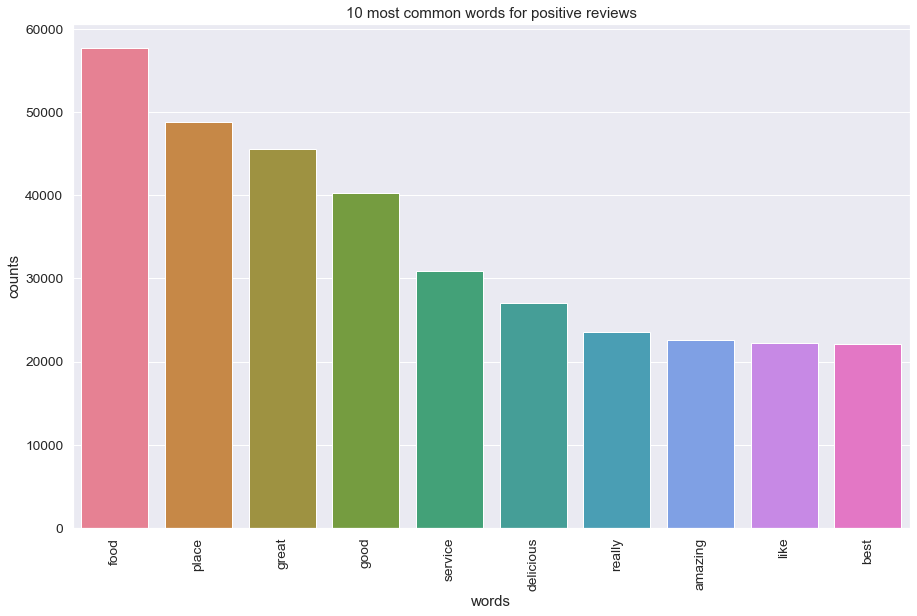

In [44]:
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words for positive reviews')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

## Sentiment Analysis for high rated reviews
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(positive_reviews['text'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [45]:
# Let's use the stop_words argument to remove words like "and, the, a"
cvec = CountVectorizer(min_df = 2, stop_words= stopwords, max_features = 1000)

cvec.fit(positive_reviews['text'])

positive_words = pd.DataFrame(cvec.transform(positive_reviews['text']).todense(),
                       columns=cvec.get_feature_names())

positive_top = positive_words.sum(axis = 0).sort_values(ascending = False).head(100)
positive_pd = pd.DataFrame(data=positive_top)
positive_top = positive_words[positive_pd.index]
positive_top.drop(columns=['food','like', 'restaurant', 'place', 'really'], inplace = True)
positive_top.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



great  good  service  delicious  one  also  amazing  back  best  time  \
0      1     0        0          0    0     0        0     0     0     0   
1      0     1        0          0    0     0        0     0     0     0   
2      1     2        0          1    0     0        1     0     2     0   
3      1     0        0          0    0     1        0     0     1     1   
4      0     0        0          0    0     0        0     0     0     0   

   definitely  go  chicken  get  would  well  try  love  friendly  menu  \
0           0   0        0    1      0     0    0     0         0     0   
1           1   0        0    0      0     0    0     1         1     0   
2           0   1        0    0      1     0    1     0         0     0   
3           0   0        0    1      0     0    0     1         0     0   
4           0   0        1    0      0     0    0     0         0     0   

   ordered  nice  fresh  toronto  staff  ...  quality  atmosphere  highly  \
0        0     0      0        0      0  ...        0           0       0   
1        0     1      0        0      1  ...        0           0       0   
2        0     0      0        0      0  ...        0           0       1   
3        0     0      0        0      0  ...        0           0       0   
4        0     0      0        0      0  ...        0           0       0   

   price  spot  two  favourite  cheese  sweet  take  table  meat  tasty  \
0      0     1    0          0       0      0     0      1     0      0   
1      0     0    0          0       0      0     0      0     0      0   
2      0     0    0          0       1      0     0      0     0      0   
3      1     0    0          0       0      0     0      0     0      0   
4      0     1    0          0       0      0     0      0     0      1   

   pretty  sure  loved  side  never  soup  could  hot  day  fish  bar  around  
0       0     0      0     0      0     0      0    0    0     0    0       0  
1       0     0      0     0      0     0      0    0    0     0    0       0  
2       0     0      0     1      0     0      0    0    0     0    3       0  
3       0     0      0     0      0     0      0    0    0     0    0       0  
4       0     0      0     0      0     0      0    0    0     0    0       0  

[5 rows x 95 columns]

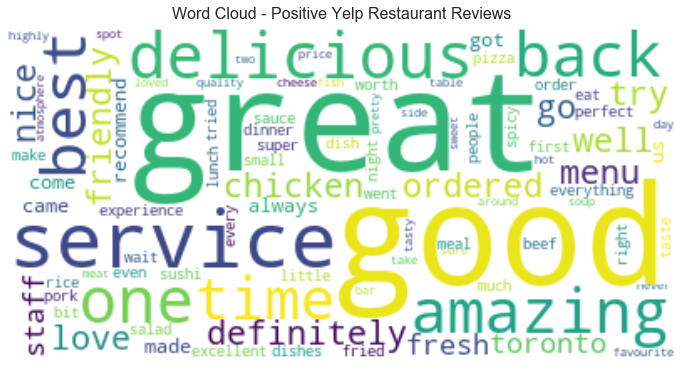

In [46]:
# Generate Word Cloud

wordcloud_high = WordCloud(background_color="white").generate(' '.join(positive_top))
plt.figure(figsize = (12,10))
plt.imshow(wordcloud_high, interpolation='bilinear')
plt.title('Word Cloud - Positive Yelp Restaurant Reviews', fontsize=16, y=1.01)
plt.axis("off");

In [47]:
positive_reviews['counter'] = 1
positive_reviews.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



business_id                 user_id  stars  useful  funny  \
2   jM6JjZXFAQQANwdlEwbH3g  IIE2OX5haarGNefY23R8BA    5.0       0      0   
3   PMPMHHLe9vFzcR67iCjgLA  RRhco4irDXPk5EJmvuwr2w    5.0       0      0   
6   28adZ4lsuUeVB2aWzohK9g  BwwqlPVsJk1dbUyNwCWB7Q    5.0       0      0   
7   uG0yvj2JWfCf0eaIgxcwXQ  yiLiYYg6MM7Pmuo6jPY4Nw    5.0       0      0   
18  Gc8xWVpbUlBYHAoOT9MTyQ  qRJQFRwFbKFx5-j3pwGRPQ    5.0       0      0   

    cool                                               text  \
2      0  My absolutely favorite mushroom pizza in the c...   
3      2  Been to this a couple of times. Excellent food...   
6      0  Amazing place! My co-workers and I went here o...   
7      0  This place is very small and cozy, but what I ...   
18     0  My wife really enjoyed the tasty foods, had th...   

                   date  year  month      time  counter  
2   2016-04-23 03:32:19  2016      4  03:32:19        1  
3   2016-01-17 05:23:59  2016      1  05:23:59        1  
6   2017-11-06 22:08:35  2017     11  22:08:35        1  
7   2015-03-07 13:40:01  2015      3  13:40:01        1  
18  2017-01-14 20:43:51  2017      1  20:43:51        1

In [48]:
# Sorting Restaurants Based on Most Reviews

positive_reviews.groupby('business_id')['counter'].sum().sort_values(ascending = False)

business_id
r_BrIgzYcwo1NAuG9dLbpg    1480
iGEvDk6hsizigmXhDKs2Vg     619
RtUvSWO_UZ8V3Wpj0n077w     460
Yl2TN9c23ZGLUBSD9ks5Uw     437
mZRKH9ngRY92bI_irrHq6w     380
                          ... 
pMaOpte9NXZXSS8wolXxGw       1
G_6iKqKNZUzxttjCp258iw       1
GW5oBBgoznV97tIap_WRZw       1
GLKVAHzymmr3rjDp7vE1WQ       1
V_P9yqnmr9Ol42VWfFjW4g       1
Name: counter, Length: 4742, dtype: int64

In [49]:
# Restaurant with most positive reviews

best_restaurant = business_final[business_final['business_id '] == 'r_BrIgzYcwo1NAuG9dLbpg']
best_restaurant

business_id                        name     city state  stars  \
1699  r_BrIgzYcwo1NAuG9dLbpg  Pai Northern Thai Kitchen  Toronto    ON    4.5   

      review_count                                         categories  \
1699          2758  Restaurants, Thai, Specialty Food, Food, Ethni...   

       latitude  longitude  is_open postal_code                     key  
1699  43.647866 -79.388685        1     M5H 3G8  r_BrIgzYcwo1NAuG9dLbpg

In [50]:
best_restaurant_reviews = positive_reviews[positive_reviews['business_id'] == 'r_BrIgzYcwo1NAuG9dLbpg']
best_restaurant_reviews

business_id                 user_id  stars  useful  funny  \
73016   r_BrIgzYcwo1NAuG9dLbpg  jAeS5gLhSQCRilgQWI2fbw    5.0       0      0   
73028   r_BrIgzYcwo1NAuG9dLbpg  Ikx6jnqAqgtd9GojOzx6qw    5.0       1      0   
73056   r_BrIgzYcwo1NAuG9dLbpg  GG4QPrqU7wxL8WVXuzozMg    5.0       0      0   
73065   r_BrIgzYcwo1NAuG9dLbpg  nnfbZsY3Z_wTGg3ZC94E_A    5.0       0      0   
73093   r_BrIgzYcwo1NAuG9dLbpg  az5i_59nAi-CzmQLYf7SUg    5.0       0      0   
...                        ...                     ...    ...     ...    ...   
99912   r_BrIgzYcwo1NAuG9dLbpg  -OdDuxIDxJq0KO8zDd2zZw    5.0       0      0   
99925   r_BrIgzYcwo1NAuG9dLbpg  RBWhXf8i7xnG5Cc-oG_W_Q    5.0       0      0   
99981   r_BrIgzYcwo1NAuG9dLbpg  rbVuebrHrOnqPXaO-oA1XQ    5.0       0      0   
100000  r_BrIgzYcwo1NAuG9dLbpg  KLq-7i65Rx2Ep51vk_ynYw    5.0       0      0   
100020  r_BrIgzYcwo1NAuG9dLbpg  G9x-ugGo1HI7J2SItKUzMg    5.0       1      0   

        cool                                               text  \
73016      0  I've been to all of Regular's restaurants in T...   
73028      0  I think they have the best Thai food in Toront...   
73056      0  This place is delicious with great service and...   
73065      0  Came back again, this time for lunch. Service ...   
73093      0  I can understand why people are raving about t...   
...      ...                                                ...   
99912      0  Hate to admit it because I'm from Los Angeles ...   
99925      0  I lucked into this gem unplanned and was so gl...   
99981      0  A true lover of Thai food this restaurant blew...   
100000     0  Funky, cool, and delicious! We loved our visit...   
100020     0  My family visited Pai on a Saturday night, the...   

                       date  year  month      time  counter  
73016   2016-04-11 17:21:26  2016      4  17:21:26        1  
73028   2018-05-28 21:07:33  2018      5  21:07:33        1  
73056   2017-07-08 18:13:21  2017      7  18:13:21        1  
73065   2015-05-12 18:18:55  2015      5  18:18:55        1  
73093   2017-09-20 16:35:52  2017      9  16:35:52        1  
...                     ...   ...    ...       ...      ...  
99912   2019-11-21 18:42:57  2019     11  18:42:57        1  
99925   2019-10-24 11:00:50  2019     10  11:00:50        1  
99981   2019-12-12 14:13:19  2019     12  14:13:19        1  
100000  2019-12-04 00:28:26  2019     12  00:28:26        1  
100020  2018-10-18 13:09:48  2018     10  13:09:48        1  

[1480 rows x 12 columns]

In [51]:
# Let's use the stop_words argument to remove words like "and, the, a"
cvec = CountVectorizer(min_df = 2, stop_words= stopwords, max_features = 1000)

cvec.fit(best_restaurant_reviews['text'])

positive_words = pd.DataFrame(cvec.transform(best_restaurant_reviews['text']).todense(),
                       columns=cvec.get_feature_names())

positive_top = positive_words.sum(axis = 0).sort_values(ascending = False).head(300)
positive_pd = pd.DataFrame(data=positive_top)
positive_top = positive_words[positive_pd.index]
positive_top.drop(columns=['food','like', 'restaurant', 'place', 'really', 'thai', 'pad', 'pai', 'khao'], inplace = True)
positive_top.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



great  curry  good  wait  best  delicious  toronto  service  time  amazing  \
0      0      0     0     0     0          0        1        0     1        0   
1      0      0     0     0     1          0        1        0     0        0   
2      1      0     0     0     0          1        1        1     0        0   
3      0      2     1     0     1          0        0        1     1        0   
4      0      0     0     0     0          0        0        0     0        0   

   get  go  one  chicken  definitely  beef  soi  ordered  would  back  dish  \
0    0   0    0        0           0     0    0        0      0     0     0   
1    0   0    0        0           0     2    1        0      1     0     0   
2    0   0    0        0           0     0    0        0      1     1     0   
3    1   0    0        1           0     2    0        0      0     1     1   
4    0   0    0        0           0     0    0        0      0     0     0   

   green  also  rice  love  ...  things  extremely  especially  saturday  \
0      0     0     1     0  ...       1          0           0         0   
1      0     0     0     0  ...       0          0           0         0   
2      0     0     0     0  ...       0          0           0         0   
3      2     0     0     0  ...       0          0           0         0   
4      0     0     0     0  ...       0          0           0         0   

   start  seating  wish  appetizers  review  able  although  visiting  dining  \
0      0        0     0           0       1     0         0         0       0   
1      0        0     0           0       0     0         0         0       0   
2      0        1     0           0       0     0         0         0       0   
3      0        0     0           0       0     0         0         0       0   
4      0        0     0           0       0     0         0         0       0   

   satay  mild  size  kind  point  server  date  room  creamy  sangria  left  \
0      0     0     0     0      0       0     0     0       0        0     0   
1      0     0     0     0      0       0     0     0       0        0     0   
2      0     0     0     0      0       0     0     0       0        0     0   
3      0     0     0     0      0       0     0     0       0        0     0   
4      0     0     0     0      0       0     0     0       0        0     0   

   maybe  
0      0  
1      0  
2      0  
3      0  
4      0  

[5 rows x 291 columns]

In [52]:
column_list = list(positive_top)
positive_words = positive_top[column_list].sum(axis=0)
positive_words = positive_words.to_frame(name = 'sum').reset_index()
positive_words.set_index('index',inplace = True)
positive_words.to_csv("Data/Part_2/positive_words.csv")

In [55]:
thumbs_up = stylecloud.gen_stylecloud(file_path="Data/Part_2/positive_words.csv", 
                                        icon_name = "fas fa-thumbs-up",
                                        size = 550,
                                        palette="colorbrewer.sequential.Greens_5", 
                                        background_color="white",
                                        output_name = 'Data/Part_2/Positive_Reviews.png')

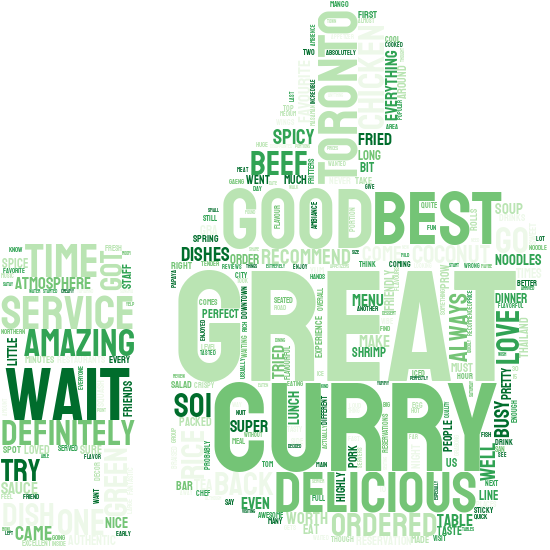

In [56]:
Image(filename='Data/Part_2/Positive_Reviews.png')

## Creating New Feature Columns

In [57]:
reviews_final.head(3)

business_id                 user_id  stars  useful  funny  cool  \
0  qUWqjjjfpB2-4P3He5rsKw  TZQSUDDcA4ek5gBd6BzcjA    4.0       0      0     0   
1  9Eghhu_LzEJgDKNgisf3rg  iFEM16O5BeKvf_AHs6NzUQ    3.0       0      0     0   
2  jM6JjZXFAQQANwdlEwbH3g  IIE2OX5haarGNefY23R8BA    5.0       0      0     0   

                                                text                 date  \
0  In the heart of Chinatown, I discovered it enr...  2017-06-06 19:04:10   
1  Was super excited to bring my boyfriend to thi...  2016-08-25 16:25:12   
2  My absolutely favorite mushroom pizza in the c...  2016-04-23 03:32:19   

   year  month      time  
0  2017      6  19:04:10  
1  2016      8  16:25:12  
2  2016      4  03:32:19

To gain more insights into the text reviews, we will be creating several new columns: `review word count`, `review character count`, `average review length`,  `number of stopwords`.

In [58]:
## Creating new feature columns
# Calculate reviews word count

reviews_final['word_count'] = reviews_final['text'].apply(lambda x: len(str(x).split(" ")))

# Calculate reviews character count

reviews_final['char_count'] = reviews_final['text'].str.len()

# Calculate average review length

def avg_word(review):
  words = review.split()
  return (sum(len(word) for word in words) / len(words))

reviews_final['avg_word_len'] = reviews_final['text'].apply(lambda x: avg_word(x))

# Calculate number of stop words in reviews

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
reviews_final['stopword_count'] = reviews_final['text'].apply(lambda x: len([x for x in x.split() if x in stopwords]))

reviews_final.head()

business_id                 user_id  stars  useful  funny  cool  \
0  qUWqjjjfpB2-4P3He5rsKw  TZQSUDDcA4ek5gBd6BzcjA    4.0       0      0     0   
1  9Eghhu_LzEJgDKNgisf3rg  iFEM16O5BeKvf_AHs6NzUQ    3.0       0      0     0   
2  jM6JjZXFAQQANwdlEwbH3g  IIE2OX5haarGNefY23R8BA    5.0       0      0     0   
3  PMPMHHLe9vFzcR67iCjgLA  RRhco4irDXPk5EJmvuwr2w    5.0       0      0     2   
4  tWdp26XQEJqJGnRmFVJQxA  IeojscL3rg3x3vtmR-hWlA    4.0       0      0     0   

                                                text                 date  \
0  In the heart of Chinatown, I discovered it enr...  2017-06-06 19:04:10   
1  Was super excited to bring my boyfriend to thi...  2016-08-25 16:25:12   
2  My absolutely favorite mushroom pizza in the c...  2016-04-23 03:32:19   
3  Been to this a couple of times. Excellent food...  2016-01-17 05:23:59   
4  The pizza is very, very good! We arrived 15 mi...  2018-07-17 01:49:01   

   year  month      time  word_count  char_count  avg_word_len  stopword_count  
0  2017      6  19:04:10         244        1442      4.709163              93  
1  2016      8  16:25:12         233        1323      4.659483              92  
2  2016      4  03:32:19          43         240      4.829268              13  
3  2016      1  05:23:59          28         148      4.321429              11  
4  2018      7  01:49:01          20         121      5.100000               7

Text(0, 0.5, 'Percentage of Reviews')

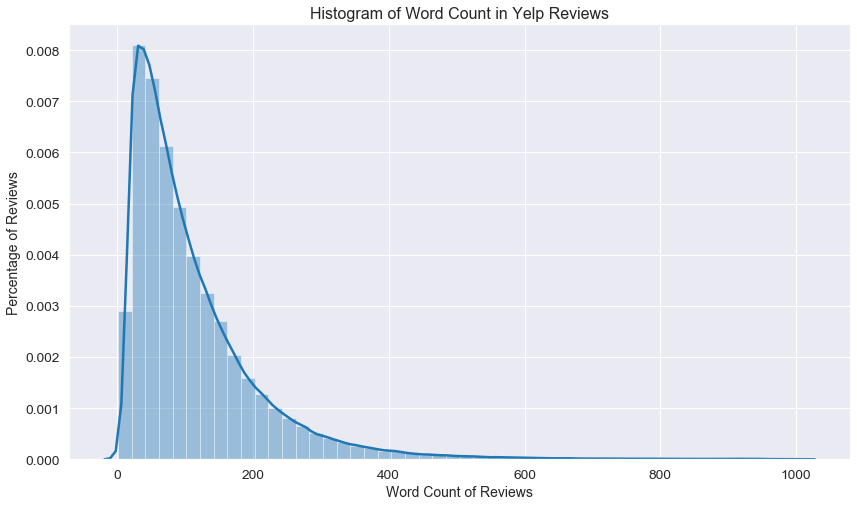

In [59]:
# Histogram of Word Count of Yelp Reviews

sns.set_style("darkgrid")
plt.figure(figsize=(14,8))
sns.distplot(reviews_final['word_count'])
plt.title('Histogram of Word Count in Yelp Reviews', fontsize = 16)
plt.xlabel('Word Count of Reviews', fontsize=14)
plt.ylabel('Percentage of Reviews', fontsize=14)

Text(0, 0.5, 'Percentage of Reviews')

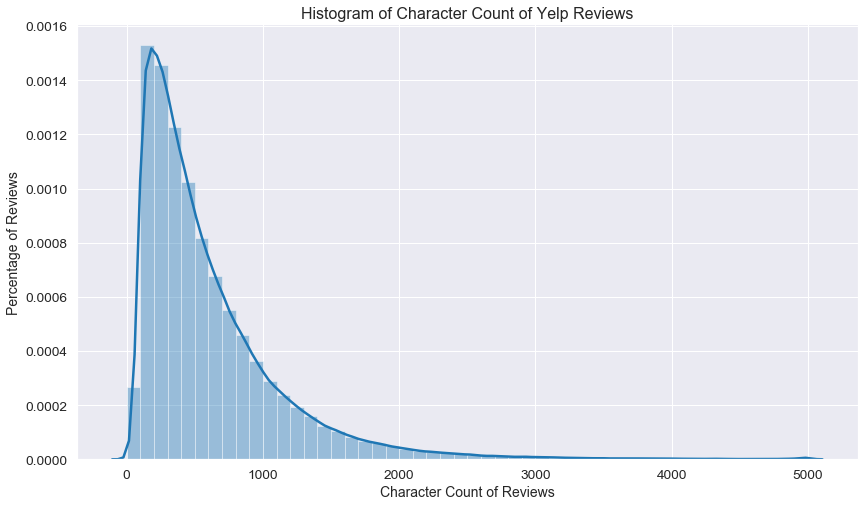

In [60]:
# Histogram of Character Count of Yelp Reviews

sns.set_style("darkgrid")
plt.figure(figsize=(14,8))
sns.distplot(reviews_final['char_count'])
plt.title('Histogram of Character Count of Yelp Reviews', fontsize = 16)
plt.xlabel('Character Count of Reviews', fontsize=14)
plt.ylabel('Percentage of Reviews', fontsize=14)

Text(0, 0.5, 'Percentage of Restaurants')

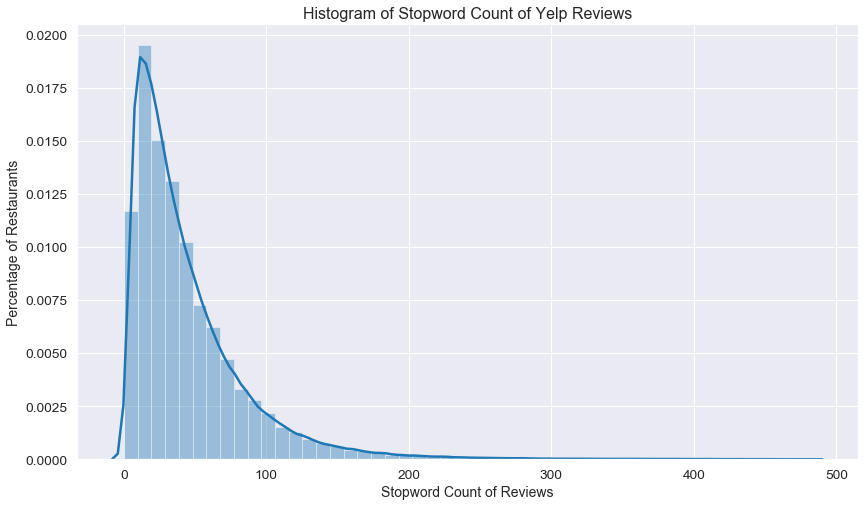

In [61]:
# Histogram of Stopword Count of Yelp Reviews

sns.set_style("darkgrid")
plt.figure(figsize=(14,8))
sns.distplot(reviews_final['stopword_count'])
plt.title('Histogram of Stopword Count of Yelp Reviews', fontsize = 16)
plt.xlabel('Stopword Count of Reviews', fontsize=14)
plt.ylabel('Percentage of Restaurants', fontsize=14)

Based on these distributions, we can see that the distributions of `Word_count`, `Char_count` and `Stopword_count` are **skewed to the right.** Most of the Yelp Reviews are relatively short and as the length of reviews increase, the less we such reviews appearing in our dataset.

In [62]:
# Average Word Length of Review for different Stars/Ratings

reviews_final.groupby('stars')['word_count'].mean()

stars
1.0    124.767896
2.0    131.809699
3.0    128.936746
4.0    114.524327
5.0     90.898294
Name: word_count, dtype: float64

In [63]:
stars_wordcount = reviews_final.groupby('stars')['word_count'].mean()
stars_wordcount = stars_wordcount.to_frame(name = 'sum').reset_index()
stars_wordcount

stars         sum
0    1.0  124.767896
1    2.0  131.809699
2    3.0  128.936746
3    4.0  114.524327
4    5.0   90.898294

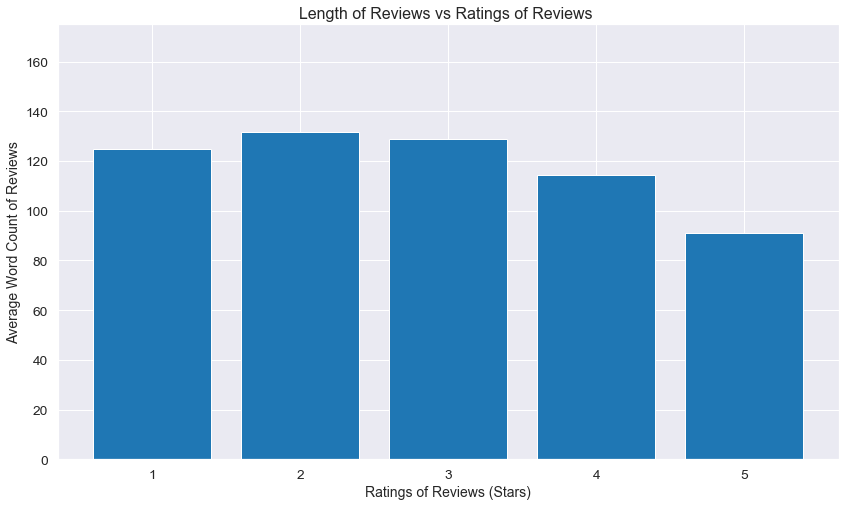

In [64]:
# Distribution of Length of Reviews vs Ratings of Reviews

sns.set_style("darkgrid")
plt.figure(figsize=(14,8))
plt.bar(stars_wordcount['stars'],stars_wordcount['sum'])
plt.title('Length of Reviews vs Ratings of Reviews ', fontsize = 16)
plt.xlabel('Ratings of Reviews (Stars)', fontsize=14)
plt.ylabel('Average Word Count of Reviews', fontsize=14)
plt.ylim((0,175))
plt.show()

Based on the distribution plot, **negative reviews** (1 and 2 Stars) are on average longer in word length as compared to **positive reviews** (5 Stars).

## Text Processing

In [65]:
# Import Textblob

from textblob import Word

# Splitting up words in reviews

reviews_final['cleaned_text'] = reviews_final['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Remove Punctuation

reviews_final['cleaned_text'] = reviews_final['cleaned_text'].str.replace('[^\w\s]', '')

# Remove Stopwords

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
reviews_final['cleaned_text'] = reviews_final['cleaned_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))

# Lemmatizing cleaned text

reviews_final['cleaned_text'] = reviews_final['cleaned_text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
reviews_final.head()

business_id                 user_id  stars  useful  funny  cool  \
0  qUWqjjjfpB2-4P3He5rsKw  TZQSUDDcA4ek5gBd6BzcjA    4.0       0      0     0   
1  9Eghhu_LzEJgDKNgisf3rg  iFEM16O5BeKvf_AHs6NzUQ    3.0       0      0     0   
2  jM6JjZXFAQQANwdlEwbH3g  IIE2OX5haarGNefY23R8BA    5.0       0      0     0   
3  PMPMHHLe9vFzcR67iCjgLA  RRhco4irDXPk5EJmvuwr2w    5.0       0      0     2   
4  tWdp26XQEJqJGnRmFVJQxA  IeojscL3rg3x3vtmR-hWlA    4.0       0      0     0   

                                                text                 date  \
0  In the heart of Chinatown, I discovered it enr...  2017-06-06 19:04:10   
1  Was super excited to bring my boyfriend to thi...  2016-08-25 16:25:12   
2  My absolutely favorite mushroom pizza in the c...  2016-04-23 03:32:19   
3  Been to this a couple of times. Excellent food...  2016-01-17 05:23:59   
4  The pizza is very, very good! We arrived 15 mi...  2018-07-17 01:49:01   

   year  month      time  word_count  char_count  avg_word_len  \
0  2017      6  19:04:10         244        1442      4.709163   
1  2016      8  16:25:12         233        1323      4.659483   
2  2016      4  03:32:19          43         240      4.829268   
3  2016      1  05:23:59          28         148      4.321429   
4  2018      7  01:49:01          20         121      5.100000   

   stopword_count                                       cleaned_text  
0              93  heart chinatown discovered enroute kensington ...  
1              92  super excited bring boyfriend scaddabush locat...  
2              13  absolutely favorite mushroom pizza city great ...  
3              11  couple time excellent food good price love tea...  
4               7  pizza good arrived 15 minute closing time rest...

## Text Classification Using Textblob

Sentiment analysis is the process of determining the attitude or the emotion of the writer/user, i.e., whether it is positive or negative or neutral.

The sentiment function of **textblob** returns two properties: **polarity** and **subjectivity**.

**Polarity** is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. 

**Subjective** sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

In [66]:
# Calculate polarity and subjectivity score

from textblob import TextBlob

reviews_final['polarity'] = reviews_final['cleaned_text'].apply(lambda x: TextBlob(x).sentiment[0])
reviews_final['subjectivity'] = reviews_final['cleaned_text'].apply(lambda x: TextBlob(x).sentiment[1])
reviews_final.head(3)

business_id                 user_id  stars  useful  funny  cool  \
0  qUWqjjjfpB2-4P3He5rsKw  TZQSUDDcA4ek5gBd6BzcjA    4.0       0      0     0   
1  9Eghhu_LzEJgDKNgisf3rg  iFEM16O5BeKvf_AHs6NzUQ    3.0       0      0     0   
2  jM6JjZXFAQQANwdlEwbH3g  IIE2OX5haarGNefY23R8BA    5.0       0      0     0   

                                                text                 date  \
0  In the heart of Chinatown, I discovered it enr...  2017-06-06 19:04:10   
1  Was super excited to bring my boyfriend to thi...  2016-08-25 16:25:12   
2  My absolutely favorite mushroom pizza in the c...  2016-04-23 03:32:19   

   year  month      time  word_count  char_count  avg_word_len  \
0  2017      6  19:04:10         244        1442      4.709163   
1  2016      8  16:25:12         233        1323      4.659483   
2  2016      4  03:32:19          43         240      4.829268   

   stopword_count                                       cleaned_text  \
0              93  heart chinatown discovered enroute kensington ...   
1              92  super excited bring boyfriend scaddabush locat...   
2              13  absolutely favorite mushroom pizza city great ...   

   polarity  subjectivity  
0  0.213835      0.532102  
1  0.188048      0.440286  
2  0.400000      0.690000

## Vader Sentiment Analysis

**VADER (Valence Aware Dictionary and Sentiment Reasoner)** is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER uses a combination of lexical features (e.g. words) which are generally labelled according to their semantic orientation as either positive or negative.

VADER has been found to be quite successful when dealing with social media texts, NY Times editorials, movie reviews, and product reviews. This is because VADER not only tells us about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is through the **compound score**.

The **compound score** is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive).

In [67]:
# Calculate Vader Sentiment Analysis Scores

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

sentiment = reviews_final['text'].apply(lambda x: analyzer.polarity_scores(x))
reviews_final = pd.concat([reviews_final,sentiment.apply(pd.Series)],1)
reviews_final.sample(5)

business_id                 user_id  stars  useful  funny  \
250112  LBQD0H2109oltJNF1raLWA  tSpEbnKOjtvY7BjIkarmcA    5.0       2      1   
217349  h_ypoQ2rmwX8UGSmohsGiQ  4hiLotPELiIRugUtWC9L6A    3.0       0      0   
252380  -jdNqqzF1Dbve04oEd4jww  m-zAuHcq5Dbu4c5nUbZpkA    5.0       0      0   
62031   MT-lkIacLNyC7KF2dY997A  H9q2XRsslW_Vu5IbkYBzYw    1.0       0      0   
237826  9tfw-OEfpF0qC2hSzRks6g  eFEfvBKQeZVz0RMbcKw5LQ    4.0       0      0   

        cool                                               text  \
250112     2  This food gave me life...all of it. I was skep...   
217349     0  Maman is a modern/country french cafe located ...   
252380     0  Awesome spot, feels like family! Great food, f...   
62031      0  Food is very average. Not worth it. Only decen...   
237826     0  Friendly staff and relaxing outdoor seating. S...   

                       date  year  month      time  word_count  char_count  \
250112  2019-08-05 02:06:09  2019      8  02:06:09          66         365   
217349  2016-11-08 23:02:58  2016     11  23:02:58         193        1003   
252380  2019-10-06 18:08:05  2019     10  18:08:05          16         102   
62031   2016-08-27 03:36:59  2016      8  03:36:59          40         214   
237826  2015-08-06 02:47:23  2015      8  02:47:23          38         236   

        avg_word_len  stopword_count  \
250112      4.545455              29   
217349      4.191710              85   
252380      5.437500               2   
62031       4.375000              15   
237826      5.378378               9   

                                             cleaned_text  polarity  \
250112  food gave lifeall skeptical mexican eye sushi ...  0.366667   
217349  maman moderncountry french cafe located upstai...  0.150797   
252380  awesome spot feel like family great food food ...  0.875000   
62031   food average worth decent thing poutine server... -0.162500   
237826  friendly staff relaxing outdoor seating sweet ...  0.596875   

        subjectivity    neg    neu    pos  compound  
250112      0.570833  0.038  0.683  0.279    0.9733  
217349      0.587609  0.059  0.764  0.177    0.9855  
252380      0.837500  0.000  0.381  0.619    0.9577  
62031       0.484375  0.318  0.682  0.000   -0.9307  
237826      0.781250  0.000  0.514  0.486    0.9806

Text(0, 0.5, 'Percentage of Restaurants')

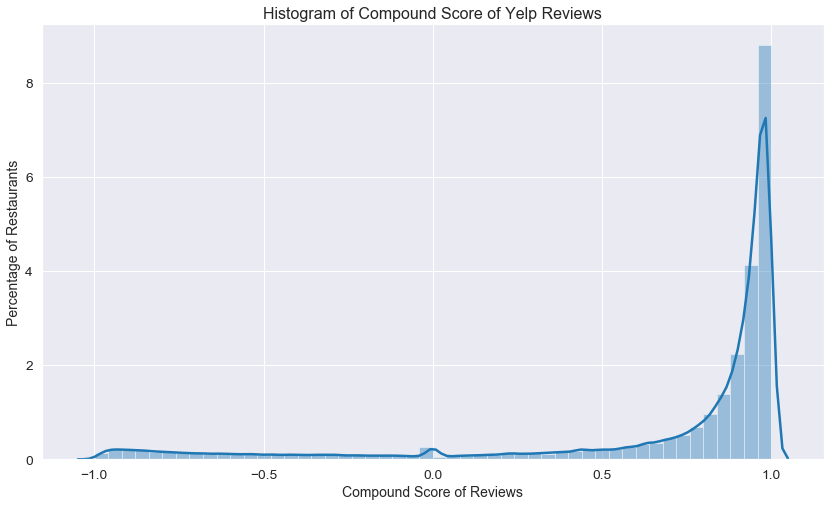

In [68]:
# Histogram of Compound Score of Yelp Reviews

sns.set_style("darkgrid")
plt.figure(figsize=(14,8))
sns.distplot(reviews_final['compound'])
plt.title('Histogram of Compound Score of Yelp Reviews', fontsize = 16)
plt.xlabel('Compound Score of Reviews', fontsize=14)
plt.ylabel('Percentage of Restaurants', fontsize=14)

This distribution is **skewed to the left** and we can infer that the majority of reviews have a compound score near **1.0** indicating that most reviews are positive reviews based on the Vader Sentiment Analysis. This is interesting when we compare this to the distribution of polarity score of the reviews as it has a more normal distribution.

Text(0, 0.5, 'Percentage of Restaurants')

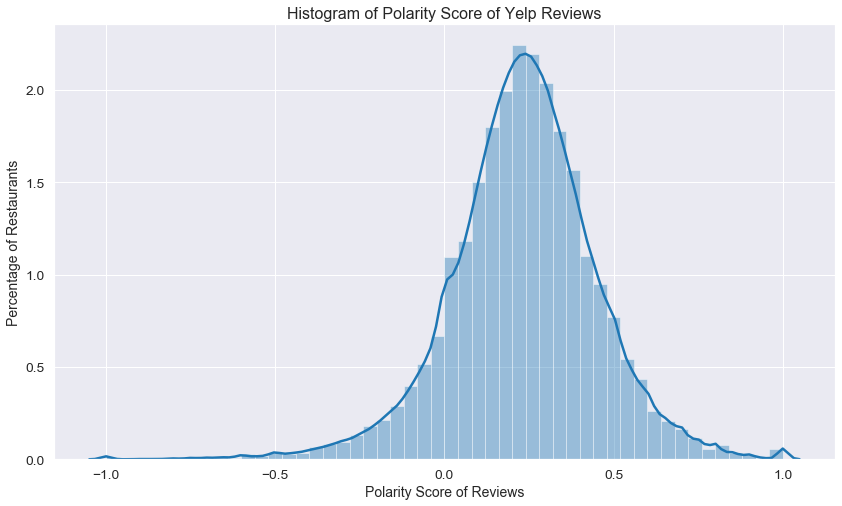

In [69]:
# Histogram of Polarity Score of Yelp Reviews

sns.set_style("darkgrid")
plt.figure(figsize=(14,8))
sns.distplot(reviews_final['polarity'])
plt.title('Histogram of Polarity Score of Yelp Reviews', fontsize = 16)
plt.xlabel('Polarity Score of Reviews', fontsize=14)
plt.ylabel('Percentage of Restaurants', fontsize=14)

This histogram follows a more normal distribution, where on average, most reviews are generally more positive (>0) than negative (<0).

Text(0, 0.5, 'Percentage of Restaurants')

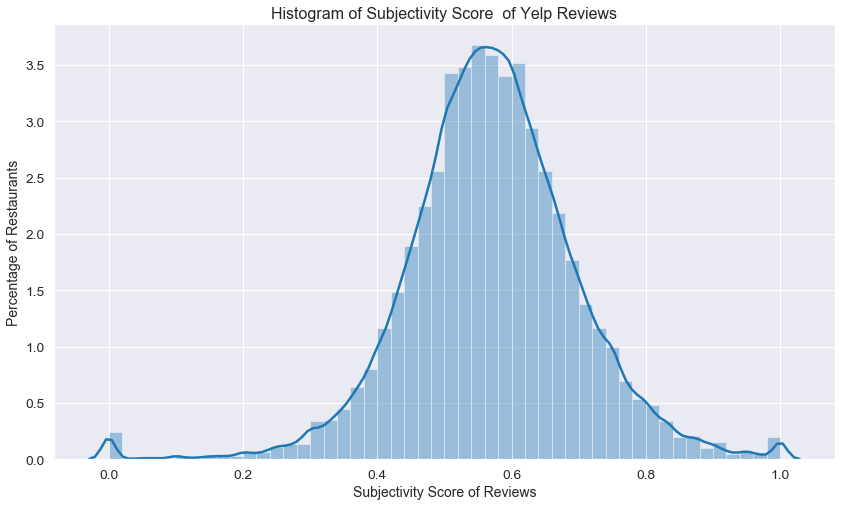

In [70]:
# Histogram of Subjectivity Score of Yelp Reviews

sns.set_style("darkgrid")
plt.figure(figsize=(14,8))
sns.distplot(reviews_final['subjectivity'])
plt.title('Histogram of Subjectivity Score  of Yelp Reviews', fontsize = 16)
plt.xlabel('Subjectivity Score of Reviews', fontsize=14)
plt.ylabel('Percentage of Restaurants', fontsize=14)

This distribution also follows a normal distribution and we can infer that on average, the majority of reviews are balanced between being subjective and objective.

Now that we have generated a few more sentiment scores, we will be combining these scores later on to build our super score rating.

In [71]:
reviews_final.shape

(253050, 22)

In [72]:
# Save combined_reviews into csv file

reviews_final.to_csv("Data/Part_2/sentiment_reviews.csv")